In [1]:
import numpy as np
import scipy.sparse as sp
import math
import matplotlib.pylab as plt

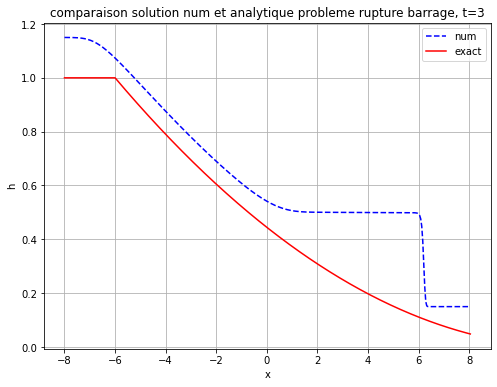

In [3]:
#
# Resolution des equations de Saint Venant instationnaires non visqueuses sur fond plat
# Solution de la rupture de barrage
# cours M1 voir
# http://www.lmm.jussieu.fr/~lagree/COURS/MFEnv/code_C_saintvenant.pdf
# exemple identique en C
# http://basilisk.fr/sandbox/M1EMN/Exemples/svdb.c


## Data 
n    = 400
xmin = -8.
xmax = +8.

L    = abs(xmax - xmin)

dx   =   L / n
dt   = .25 * dx

# Space

x    = np.zeros(n+2)

for i in range(n+2):
    x[i] = (i - n / 2) * dx

# -------------------------

# Initialisation
u    = np.zeros(n+2)
h    = np.zeros(n+2)

# Initial height
h0   = 1.
h[:] = h0*(x[:] < 0) + .15

# --------------------------

def FR1(ug, ud, hg, hd):
     
    """ Rusanov numerical flux for height """

    c = max(abs(ug) + np.sqrt(hg), abs(ud) + np.sqrt(ud))
    
    return (hg*ug + hd*ud) * 0.5 - c*(hd-hg) * 0.5  # Numerical flux (mean - correction)

# --------------------------

def FR2(ug, ud, hg, hd):
    
    """ Rusanov numerical flux for movement qtty """
    
    c = max(abs(ug) + np.sqrt(hg), abs(ud)+np.sqrt(ud))
    
    return (ug*ug*hg + hg*hg/2. + ud*ud*hd + hd*hd/2.) * 0.5 - c*(hd*ud - hg*ug)*0.5

# --------------------------

## Numerical solution

def sol_num(t) :

    """ Definition de l'avancee au temps t """

    fp = np.zeros(n+2)
    fd = np.zeros(n+2)
    
    nt = int(t/dt)
    t  = 0

    # --------------------------

    # boucle en temps
    for k in range(nt):
        t = t + dt

    # pour chaque x, calcul des flux mis dans un tableau 
        # le cacul est pour h[1] a h[n] et pour u[1] a u[n]   
        for i in range(1, n+2):
            fp[i] = FR1(u[i-1], u[i], h[i-1], h[i])
            fd[i] = FR2(u[i-1], u[i], h[i-1], h[i])
        
        # avancee pour h, si h>0 avancee pour u      
        for i in range(1, n+1):
            hn = h[i] - dt*(fp[i+1] - fp[i])/dx

            ## i.   We calculate hn == hn+1 from finite volume scheme on height (1st SW equation with Rusanov flux)
            ## ii.  Then we save an intermediate value qn+1 (==q) using again a finite volume scheme. Note that we only use un and hn to do so, note using hn+1 calculated here above.
            ## iii. Finally we calculate un+1 from qn+1 and hn+1 (q/hn)

            if(h[i] > 0.):
                q    = h[i]*u[i] - dt*(fd[i+1] - fd[i])/dx
                u[i] = q / hn
                h[i] = hn
            else:
                u[i] = 0.
                h[i] = hn 
            
    #condition de neumann en 0 et en n         
        u[0]   = u[1]
        h[0]   = h[1]
        
        h[n+1] = h[n]
        u[n+1] = u[n]
    return h

# ---------------------------------------------

## Exact solution

def sol_exact(x, t):
    
    """ Exact solution """
    
    h_exact = (((x-0) <= -t) + ((x-0) > -t) * (2./3 * (1 - (x - 0)/(2*t)))**2) * (((x - 0) <= 2*t))
    
    return h_exact

#test au temps t
T   = 6
h3n = np.zeros(n+2)
h3n = sol_num(T)
h3e = sol_exact(x,T)

# on compare la solution analytique et la solution numerique au temps 3
# verifier que plus n est grand plus la solution numerique est proche de la solution analytique (convergence)
# verifier que dt < dx pour que ce soit stable (condition de CFL)

plt.figure(figsize=(8,6))

plt.plot(x, h3n, 'b', linestyle='--', label='num')
plt.plot(x, h3e, 'r', label='exact')

plt.title('comparaison solution num et analytique probleme rupture barrage, t=3')
plt.ylabel('h')
plt.xlabel('x')

plt.grid()
plt.legend(loc='best')

plt.show()